# Connectivity-based Parcellation with fsl matrices

We'll start with the standard imports. All of the below packages come with anaconda.

In [1]:
import numpy as np
import scipy.sparse as ss
import nibabel as nib
import nilearn.plotting as plt
from sklearn.cluster import KMeans

/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


If using fsl/probtrackx, we'll use the matrix2 option to cluster an roi. Probtrackx will generate a file called 'fdt_matrix2.dot'. We use numpy to read the file and use scipy to store it. The fdt matrix starts with 1, but scipy adds a 0 upfront so we'll remove it.

In [ ]:
# row,col,data = np.loadtxt('fdt_matrix2.dot', unpack=True)
# row, col = row.astype(np.int32), col.astype(np.int32)
# data = data.astype(np.float64)
# mat = scipy.sparse.coo_matrix((data,(row,col)))[1:,1:]

# Load Data
To get at the similarity of connectivity, we'll generate a correlation matrix. Because the dense form of the matrix fits comfortably in memory on my computer I can just make the matrix dense and then use np.corrcoef. We could also try to calculate it ourselves based on $AA^T$. A good option in the future will be to use dask.array and pydata/sparse.

In [2]:
mat = ss.load_npz('combined_103matrix.npz').todense()[1:,1:]
CC = np.corrcoef(mat)
CC = np.nan_to_num(CC)

# Cluster using KMeans
Now we'll call kmeans for each number of clusters that we want. We add a 1 to output so because values that are 0 will be indistinguishable from the zeros in the nifti file that we'll create.

In [3]:
labels = [KMeans(n_clusters=i).fit_predict(CC) + 1 for i in range(2,6)]

# Convert clustering solutions into nifti files
Probtrackx outputs a file called 'coords_for_fdt_matrix2' that contains the xyz voxel locations of the entries in the matrix.

In [4]:
images = [np.zeros([91,109,91]) for l in labels]
x,y,z,_,_ = np.loadtxt('coords_for_fdt_matrix2',unpack=True)
x,y,z = x.astype(np.int32),y.astype(np.int32),z.astype(np.int32)

In [5]:
mni = nib.load('/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz')
header = mni.header
affine = mni.affine
files = []
for lbs,img in zip(labels,images):
    img[x,y,z] = lbs
    header['cal_min'] = img.min()
    header['cal_max'] = img.max()
    files.append(nib.nifti1.Nifti1Image(img,affine=affine,header=header))

# Plot clusters

/anaconda2/envs/python3/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:310: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


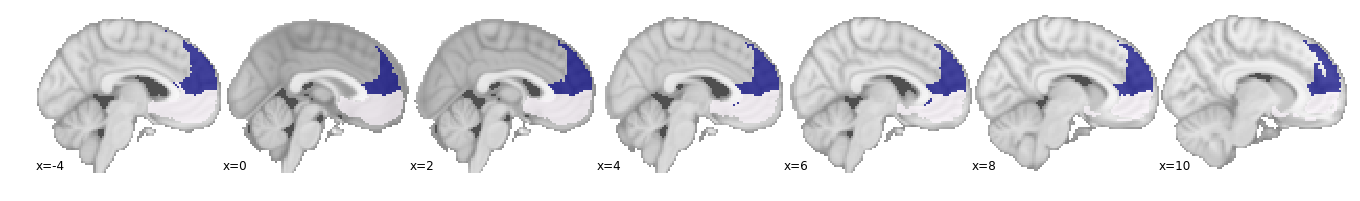

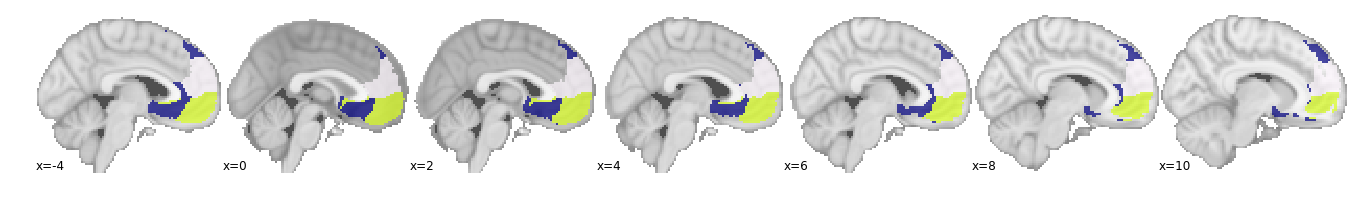

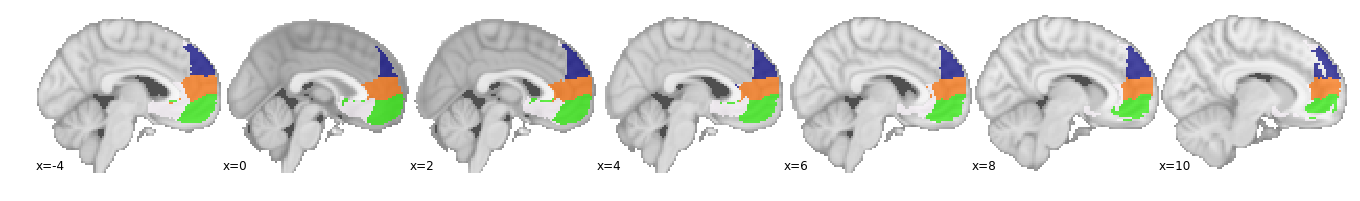

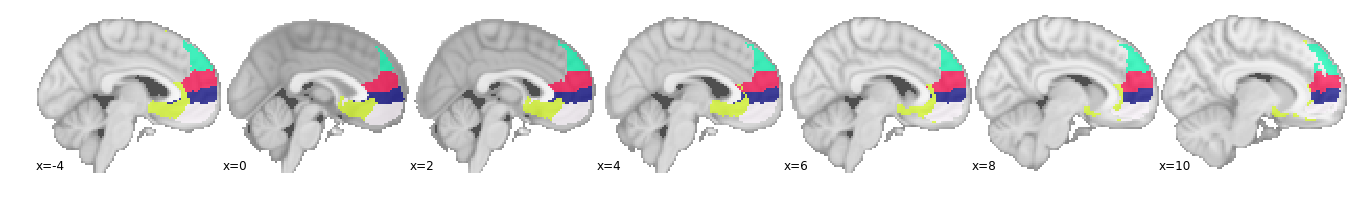

In [6]:
for f in files:
    plt.plot_roi(f,display_mode='x')